## 1-period, 2-player MARL setting

Changes made
* Env:
  * Changed obs to be `I: [v, p0, sigma_v, sigma_u]` and `MM: [y, p0, sigma_v, sigma_u]`
    * made order consistent (`v, y` at start and distribution params at the end), also changed any code that does e.g. `obs[0]=v` to account for that
    * removed `**2` from the stdevs
  * action scaling as an explicit variable that gets passed to `Env` at init, and into the training & eval functions
* Agents:
  * made 2-hidden-layer by default (was 1-hidden-layer), adjustable number of neurons per hidden layer (`hidden_dim` at init)
  * made Tanh on output optional (specify with `output_tanh=True/False` at init)
  * added `.predict()` method used at eval time: this one either outputs the mean (`deterministic=True`) or samples an action from the dist (`deterministic=False`). At inference (eval) you want to use deterministic actions, i.e. the mean. During training, we're still using `.forward()` as before, which outputs the mean and std (this is convention). 
* Added OptimalAgents
  * purpose: if you want to train vs a fixed agent
  * can be used for training & eval just like a `GaussianPolicy` agent. training functions are adjusted to not try to backprop into these agents (because they don't have any parameters with `require_grad=True`).
* Train functions
  * defined functions for individual and batched training
  * include eval via plotting learned order/price functions at regular intervals  
* Eval functions
  * added my action (order/price function) plotting function
  * made Kristijan's plotting functions consistent: blue dotted is baseline, orange is agent
  * cleaned up Kristijan's profit plotting functions: 
    * now clear about what's being eval'd. E.g. when plotting insider profit, distinguish between simulating `trained I vs trained MM`, `trained I vs optimal MM`, `optimal I vs optimal MM`
    * fixed randomness

## Imports & Definitions

In [1]:
import numpy as np
import functools
from pettingzoo import AECEnv
from gymnasium import spaces
from pettingzoo.utils.agent_selector import agent_selector
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Eval function definitions

Equilibrium parameters and actions:

In [2]:
def get_kyle_eq_params(mean_v, sigma_v, sigma_u):
    beta = sigma_u / sigma_v  # Insider's coefficient
    lambda_ = 0.5 * sigma_v / sigma_u  # MM's coefficient
    return beta, lambda_

def equilibrium_insider_action(v, mean_v, sigma_v, sigma_u):
    beta, _ = get_kyle_eq_params(mean_v, sigma_v, sigma_u)
    return beta * (v - mean_v)

def equilibrium_market_maker_action(y, mean_v, sigma_v, sigma_u):
    _, lambda_ = get_kyle_eq_params(mean_v, sigma_v, sigma_u)
    return mean_v + lambda_ * y

### Env & Agent definitions

In [3]:
class KyleOnePeriodAEC(AECEnv):
    metadata = {
        "render_modes": ["human"],
        "name": "KyleOnePeriodAEC",
    }

    def __init__(self, sigma_v=2.0, sigma_u=1.0, p0=0.5, gamma=0.9, action_scaling=5, T=1):
        super().__init__()
        self.sigma_v_initial = sigma_v
        self.sigma_u_initial = sigma_u
        self.p0_initial = p0
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.timestep = 0
        self.gamma = gamma
        self.T = T

        self.possible_agents = ["insider", "market_maker"]
        self.agents = self.possible_agents[:]
        self.render_mode = None
        self.rewards = {a: 0 for a in self.agents}
        self.agent_selector = agent_selector(self.agents)

        self.action_spaces = {
            "insider": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        }

        self.observation_spaces = {
            "insider": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }
        self.action_scaling = action_scaling

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {a: 0 for a in self.agents}
        self._cumulative_rewards = {a: 0 for a in self.agents}
        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}
        self.infos = {a: {} for a in self.agents}
        self.timestep = 0
        self.sigma_v = self.sigma_v_initial
        self.sigma_u = self.sigma_u_initial
        self.p0 = self.p0_initial
        self.optimal_x = 0
        self.optimal_y = 0

        # Sample true value
        self.v = torch.normal(self.p0, self.sigma_v, size=(1,)).item()
        self.u = torch.normal(0, self.sigma_u, size=(1,)).item()
        self.p = 0
        self.y = 0

        # Set first agent
        self.agent_selector.reinit(self.agents)
        self.agent_selection = self.agent_selector.next()


    def observe_insider(self):
        return torch.tensor([self.v, self.p0, self.sigma_v, self.sigma_u], dtype=torch.float32)

    def observe_market_maker(self):
        return torch.tensor([self.y, self.p0, self.sigma_v, self.sigma_u], dtype=torch.float32)

    def observe(self, agent):
        if agent == "insider":
            return self.observe_insider()
        elif agent == "market_maker":
            return self.observe_market_maker()

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]

    def step(self, action):
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            return self._was_dead_step(action)

        agent = self.agent_selection

        # Store the action
        if agent == "insider":


            self.insider_action = action[0] * self.action_scaling
            self.u = torch.normal(0, self.sigma_u, size=(1,)).item()
            self.y = self.insider_action + self.u

        elif agent == "market_maker":
            self.market_maker_action = action[0] * self.action_scaling


            insider_profit = (self.v - self.market_maker_action) * self.insider_action 
            market_maker_loss = - (self.market_maker_action - self.v) ** 2

            # Assign rewards
            self.rewards = {
                "insider": insider_profit,
                "market_maker": market_maker_loss
            }

            if self.T > 1:
                beta_, lambda_ = get_kyle_eq_params(self.p0, self.sigma_v, self.sigma_u)

                self.optimal_x = equilibrium_insider_action(self.v, self.p0, self.sigma_v, self.sigma_u)
                self.optimal_y = self.optimal_x + self.u

                self.p0 = self.p0 + lambda_ * self.optimal_y
                self.sigma_v = 0.5 * self.sigma_v  # update sigma_v for next round

            # Update timestep
            self.timestep += 1
            if self.timestep >= self.T:
                self.terminations = {a: True for a in self.agents}

            # Update cumulative rewards
            for a in self.agents:
                self._cumulative_rewards[a] += self.rewards[a]

        # Get next agent
        self.agent_selection = self.agent_selector.next()

    def render(self):
        new_obs = self.observe(self.agent_selection)
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        print(f"observations insider: {new_obs}" if self.agent_selection == "insider" else f"observations market_maker: {new_obs}")
        if hasattr(self, 'rewards'):
            print(f"Agents' rewards: {self._cumulative_rewards}")

    def close(self):
        pass

Policy / Actor definition. 

*Note: this is a 2-hidden-layer arch (default for PPO), can use either ReLU or Tanh activations. For [-1,1] actions people often use Tanh. Experiment with what works better.*

In [4]:
class GaussianActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64, activation_fn=nn.Tanh, output_tanh=False):
        super().__init__()
        # self.fc = nn.Sequential(
        #     nn.Linear(obs_dim, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, act_dim)
        # )
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn()
        )
        self.mean = nn.Linear(hidden_dim, act_dim)
        self.log_std = nn.Linear(hidden_dim, act_dim) # State-dependent std
        self.output_tanh = output_tanh

    def forward(self, x):
        x = self.net(x)
        if self.output_tanh:
            mean = torch.tanh(self.mean(x))
        else:
            mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, -8, -1)  # Prevent extreme values    
        std = log_std.exp()
        return mean, std

    def predict(self, x, deterministic=False):
        with torch.no_grad():
            mean, std = self.forward(x)  # equivalent to self(x)
            if deterministic:
                action = mean
            else:
                action = torch.normal(mean, std)
            action = action.detach().numpy()
            if len(x.shape) == 1:  # single observation, would otherwise be returned as array(action), want just the action
                action = action[0]
        return action

In [5]:
class GaussianActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64, activation_fn=nn.Tanh, output_tanh=False):
        super().__init__()
        # self.fc = nn.Sequential(
        #     nn.Linear(obs_dim, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, act_dim)
        # )
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn()
        )
        self.mean = nn.Linear(hidden_dim, act_dim)  # this is what we get actions from
        self.log_std = nn.Parameter(torch.ones(act_dim) * - 2.5, requires_grad=True)
        self.output_tanh = output_tanh

    def forward(self, x):
        x = self.net(x)
        if self.output_tanh:
            mean = torch.tanh(self.mean(x))
        else:
            mean = self.mean(x)  
        # std = torch.exp(self.log_std)
        std = self.log_std.exp().expand_as(mean)
        return mean, std

    def predict(self, x, deterministic=False):
        with torch.no_grad():
            mean, std = self.forward(x)  # equivalent to self(x)
            if deterministic:
                action = mean
            else:
                action = torch.normal(mean, std)
            action = action.detach().numpy()
            if len(x.shape) == 1:  # single observation, would otherwise be returned as array(action), want just the action
                action = action[0]
        return action

In [6]:
class Critic(nn.Module):
    def __init__(self, obs_dim, hidden_dim=64, activation_fn=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, 1)  # Output: V(s)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)  # Return scalar value per observation


### Tests for env & agents

Test defining env & agents, and stepping env with deterministic `predict()` actions (what happens during eval)

In [7]:
# test env definition etc
env = KyleOnePeriodAEC(T=1)  # play 3 periods to test multiple steps

# reset
observations = env.reset()
done = False

# define dummy agents
activation_fn = nn.ReLU

policies = {
    "insider": GaussianActor(obs_dim=4, act_dim=1, hidden_dim=32, activation_fn=activation_fn),
    "market_maker": GaussianActor(obs_dim=4, act_dim=1, hidden_dim=32, activation_fn=activation_fn)
}

# test stepping env until it terminates (with predict())
print("=== stepping with .predict(), simulating eval (deterministic) ===")
while not done:  # stops automatically when all agents are done

    
    agent = env.agent_selection
    obs = env.observe(agent)

    action = policies[agent].predict(obs, deterministic=True) if not env.terminations[agent] else None
    action = torch.tensor([action], dtype=torch.float32)


    env.step(action)
    env.render()

        
    if env.timestep >= env.T:
        done = True
        print("--all agents done after this one--")



=== stepping with .predict(), simulating eval (deterministic) ===
Step: 0
True value v: 2.57
Order flow y: -0.27
observations market_maker: tensor([-0.2726,  0.5000,  2.0000,  1.0000])
Agents' rewards: {'insider': 0, 'market_maker': 0}
Step: 1
True value v: 2.57
Order flow y: -0.27
observations insider: tensor([2.5698, 0.5000, 2.0000, 1.0000])
Agents' rewards: {'insider': tensor(-6.5652), 'market_maker': tensor(-19.3781)}
--all agents done after this one--


Function that evals and plots the learned functions, so:
* insider: plot `order(value)`, $I(v) = x$
* market maker: plot `price(order_I + order_noise)`, $MM(y) = p$

dummy optimal insiders and market makers to train against (can drop these in the policies training loop)

In [8]:
class OptimalInsider(nn.Module):
    def __init__(self, p0, sigma_v, sigma_u, action_scaling):
        super().__init__()
        self.dummy_param = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.p0 = p0
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.action_scaling = action_scaling  # need b/c any action sampled from this will be scaled by the factor

    # def parameters(self):
    #     return iter([self.dummy_param])

    def forward(self, x):
        v = float(x[0])
        mean_action = equilibrium_insider_action(v, self.p0, self.sigma_v, self.sigma_u) / self.action_scaling
        mean = torch.tensor([mean_action], requires_grad=False)
        std = torch.tensor(1e-10, requires_grad=False).expand_as(mean)
        return mean, std
    
    def predict(self, x, deterministic=True):
        mean, std = self.forward(x)
        if deterministic:
            return mean
        else:
            return torch.normal(mean, std)
    
class OptimalMarketMaker(nn.Module):
    def __init__(self, p0, sigma_v, sigma_u, action_scaling):
        super().__init__()
        self.dummy_param = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.p0 = p0
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.action_scaling = action_scaling

    # def parameters(self):
    #     return iter([self.dummy_param])

    def forward(self, x):
        y = float(x[0])
        mean_action = equilibrium_market_maker_action(y, self.p0, self.sigma_v, self.sigma_u) / self.action_scaling
        mean = torch.tensor([mean_action], requires_grad=False)
        std = torch.tensor(1e-10, requires_grad=False).expand_as(mean)
        return mean, std
    
    def predict(self, x, deterministic=True):
        mean, std = self.forward(x)
        if deterministic:
            return mean
        else:
            return torch.normal(mean, std)
    

In [9]:
def evaluate_agent_actions(models, env, n_stdevs, action_scaling=5):
    """plots insider and market maker actions from agents vs equilibrium
    Args:
        models: dict of models, indexed with ["insider"], ["market_maker"]
        env: environment instance (pettingzoo AEC)
        n_stdevs: number of standard deviations to plot as minimum/maximum x-value
    """
    I = models["insider"]
    MM = models["market_maker"]

    num_points = 100
    min_price = env.p0 - n_stdevs * env.sigma_v
    max_price = env.p0 + n_stdevs * env.sigma_v
    min_order = -n_stdevs*env.sigma_u
    max_order = n_stdevs*env.sigma_u

    values = np.linspace(min_price, max_price, num_points)
    orders = np.linspace(min_order, max_order, num_points)

    optimal_insider_actions = np.zeros((num_points))
    optimal_market_maker_actions = np.zeros((num_points))
    trained_insider_actions = np.zeros((num_points))
    trained_market_maker_actions = np.zeros((num_points))

    for i in range(len(values)):
        v = values[i]
        y = orders[i]

        obs_I = torch.tensor([v, env.p0, env.sigma_v, env.sigma_u], dtype=torch.float32)
        obs_MM = torch.tensor([y, env.p0, env.sigma_v, env.sigma_u], dtype=torch.float32)

        # optimal actions
        optimal_insider_actions[i] = equilibrium_insider_action(v, env.p0, env.sigma_v, env.sigma_u)
        optimal_market_maker_actions[i] = equilibrium_market_maker_action(y, env.p0, env.sigma_v, env.sigma_u)

        mu, std = I.forward(obs_I)
        print(std)

        # actual agent actions
        trained_insider_actions[i] = I.predict(obs_I, deterministic=True) * action_scaling
        trained_market_maker_actions[i] = MM.predict(obs_MM, deterministic=True) * action_scaling
    
    # plot: 2 subplots. one for insider (values vs action) and one for market maker (order vs action)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Insider subplot
    ax1.plot(values, optimal_insider_actions, label="Optimal", linestyle='--')
    ax1.plot(values, trained_insider_actions, label="Trained", linestyle='-')
    ax1.axvline(x=env.p0, color='black', linestyle=':', alpha=0.5)
    ax1.axhline(y=0, color='black', linestyle=':', alpha=0.5)
    ax1.set_title("Insider Action")
    ax1.set_xlabel("Value v")
    ax1.set_ylabel("Action x")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Market Maker subplot
    ax2.plot(orders, optimal_market_maker_actions, label="Optimal", linestyle='--')
    ax2.plot(orders, trained_market_maker_actions, label="Trained", linestyle='-')
    ax2.axvline(x=0, color='black', linestyle=':', alpha=0.5)
    ax2.axhline(y=env.p0, color='black', linestyle=':', alpha=0.5)
    ax2.set_title("Market Maker Action")
    ax2.set_xlabel("Order y")
    ax2.set_ylabel("Price p")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show() 
        

### Train function definitions
* individual: rollout 1 episode, update agents, repeat for `num_episodes` steps
* batched: rollout `batch_size` episodes, update agents (on mean batch rewards, normalized), repeat for `num_iterations` steps
  * --> total of `num_iterations * batch_size` episodes rolled out

Need to experiment which is better! To me it seems individual is winning?

In [10]:
def compute_returns(rewards, gamma=1.0):
    returns = []
    G = 0
    if len(rewards) > 1:
        # Normalize returns in REINFORCE
        returns1 = torch.tensor(rewards)
        returns1 = (returns1 - returns1.mean()) / (returns1.std() + 1e-8)
    
    rewards = returns1.numpy() if len(rewards) > 1 else rewards
    rewards = rewards.tolist() if isinstance(rewards, np.ndarray) else rewards

    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    return returns

In [11]:
loss_debug = []

In [12]:
def train_both_reinforce_individual(policies, optimizers, env, num_episodes=10000, plot_every=None, action_scaling=5):
    """trains both agents using REINFORCE, via `rollout 1 episode, update agents, repeat`
    """
    if plot_every is None:
        plot_every = num_episodes // 10
    
    for episode in range(num_episodes):
        # Reset environment
        env.reset()

        done = False
        log_probs = {a: [] for a in env.possible_agents}
        rewards = {a: [] for a in env.possible_agents}

        # rollout 1 episode
        while not done:  # while there are still live agents

            agent = env.agent_selection  # whose turn is it?

            obs_I = env.observe(agent)

            # get action via forward() & sampling
            mu, std = policies[agent](obs_I)
            
            dist = torch.distributions.Normal(mu, std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum()

            env.step(action.detach().numpy())  # step only this agent!

            if agent == "market_maker":
                for agent in env.agents:
                    rewards[agent].append(env.rewards[agent])
            
            # record log_prob for update
            log_probs[agent].append(log_prob)
            
            if env.timestep >= env.T:
                done = True
                
        # --- Compute returns ---
        for agent in env.agents:
            rewards[agent] = compute_returns(rewards[agent], env.gamma)
            rewards[agent] = torch.tensor(rewards[agent], dtype=torch.float32)

        # --- Policy Gradient Update (REINFORCE) ---
        for agent in env.possible_agents:
            # if agent is optimal, skip training attempt
            if not any(p.requires_grad for p in policies[agent].parameters()):
                continue
            
            if len(rewards[agent]) == 0:
                continue
            
            loss = -torch.sum(torch.stack([
                log_prob * G_t for log_prob, G_t in zip(log_probs[agent], rewards[agent])
            ]))
            loss_debug.append(loss.item())
            optimizers[agent].zero_grad()
            loss.backward()
            optimizers[agent].step()

        # Eval loop
        if env.T == 1:
            if (episode+1) % plot_every == 0:
                print(f"Episode: {episode+1}")
                evaluate_agent_actions(policies, env, 2, action_scaling)

    return policies, optimizers

## Training
Set up env, agents, optimizers.

**Note:** for action scaling, can either specify scale factor at env definition (default is 5 like before)
```
env = KyleOnePeriodAEC(action_scaling=action_scale_factor)
```

or via creating the env without scaling, and wrapping it with supersuit
```
env = KyleOnePeriodAEC(action_scaling=1)
env = scale_actions_v0(env_unscaled, scale=action_scale_factor)
```


In [13]:
#### PARAMS ####
action_scale_factor = 5  # defaults to 5 in env & training function definitions
activation_fn = nn.ReLU  # activations for hidden layers. or nn.Tanh (experiment what's better)
output_tanh = False  # if True, puts output through nn.Tanh to ensure [-1,1] (experiment)
hidden_dim = 32
################

env = KyleOnePeriodAEC(action_scaling=action_scale_factor, T=1) 
env.reset()

I_obs_dim = env.observation_spaces["insider"].shape[0]
I_act_dim = env.action_spaces["insider"].shape[0]
MM_obs_dim = env.observation_spaces["market_maker"].shape[0]
MM_act_dim = env.action_spaces["market_maker"].shape[0]
policies = {
    "insider": GaussianActor(obs_dim=I_obs_dim, act_dim=I_act_dim, hidden_dim=hidden_dim, activation_fn=activation_fn, output_tanh=output_tanh),
    "market_maker": GaussianActor(obs_dim=MM_obs_dim, act_dim=MM_act_dim, hidden_dim=hidden_dim, activation_fn=activation_fn, output_tanh=output_tanh)
}
optimizers = {a: optim.Adam(policies[a].parameters(), lr=1e-4) for a in policies}

Observe (after 20k episodes of single training)) 
* activations Tanh, output Tanh: action function too tanh-shaped to converge
* activations Tanh, output raw: not quite as much, but still
* activations ReLU, output Tanh: decent convergence
* activations ReLU, output raw: seems very similar tbh

### Training via "1 rollout, 1 update, repeat".
* `plot_every` means 'every X iterations, do a round of eval/plotting'. If you leave it as None it'll do it 10 times over the course of the run

*Note: unless you reinitialize policies & optimizers, this will continue training existing policies when cell is executed again*

In [ ]:
num_episodes = 250_000
plot_every = None # 1_000  # if leave "None", will plot 10 times over the course of training
policies, optimizers = train_both_reinforce_individual(policies, optimizers, env, num_episodes, plot_every, action_scale_factor)

### Training via: "`batch_size` rollouts, 1 update (on batched means), repeat".

*Note: unless you reinitialize policies & optimizers, this will continue training existing policies when cell is executed again*

In [15]:
#### PARAMS ####
action_scale_factor = 5
activation_fn = nn.ReLU  # activations for hidden layers. or nn.Tanh (experiment what's better)
output_tanh = False  # if True, puts output through nn.Tanh to ensure [-1,1] (experiment)
hidden_dim = 32
################

env = KyleOnePeriodAEC(action_scaling=action_scale_factor, T=1) 
env.reset()

I_obs_dim = env.observation_spaces["insider"].shape[0]
I_act_dim = env.action_spaces["insider"].shape[0]
MM_obs_dim = env.observation_spaces["market_maker"].shape[0]
MM_act_dim = env.action_spaces["market_maker"].shape[0]
policies_batched = {
    "insider": GaussianActor(obs_dim=I_obs_dim, act_dim=I_act_dim, hidden_dim=hidden_dim, activation_fn=activation_fn, output_tanh=output_tanh),
    "market_maker": GaussianActor(obs_dim=MM_obs_dim, act_dim=MM_act_dim, hidden_dim=hidden_dim, activation_fn=activation_fn, output_tanh=output_tanh)
}
optimizers_batched = {a: optim.Adam(policies_batched[a].parameters(), lr=2e-4) for a in policies_batched}

### Example: training insider vs fixed optimal MM:

In [16]:
#### PARAMS ####
action_scale_factor = 5  # defaults to 5 in env & training function definitions
activation_fn = nn.ReLU  # activations for hidden layers. or nn.Tanh (experiment what's better)
output_tanh = False  # if True, puts output through nn.Tanh to ensure [-1,1] (experiment)
hidden_dim = 32
################

env = KyleOnePeriodAEC(action_scaling=action_scale_factor, T=1) 
env.reset()

I_obs_dim = env.observation_spaces["insider"].shape[0]
I_act_dim = env.action_spaces["insider"].shape[0]
MM_obs_dim = env.observation_spaces["market_maker"].shape[0]
MM_act_dim = env.action_spaces["market_maker"].shape[0]
policies_trainI_optMM = {
    "insider": GaussianActor(obs_dim=I_obs_dim, act_dim=I_act_dim, hidden_dim=hidden_dim, activation_fn=activation_fn, output_tanh=output_tanh),
    "market_maker": OptimalMarketMaker(p0=env.p0, sigma_v=env.sigma_v, sigma_u=env.sigma_u, action_scaling=action_scale_factor)
}
optimizers_trainI_optMM = {a: optim.Adam(policies_trainI_optMM[a].parameters(), lr=2e-4) for a in policies_trainI_optMM}

Episode: 2500
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], grad_fn=<ExpandBackward0>)
tensor([0.0799], g

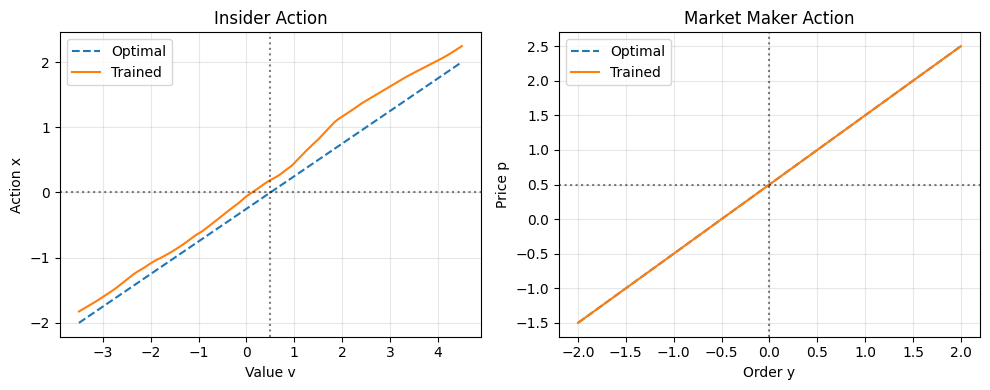

Episode: 5000
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], grad_fn=<ExpandBackward0>)
tensor([0.0757], g

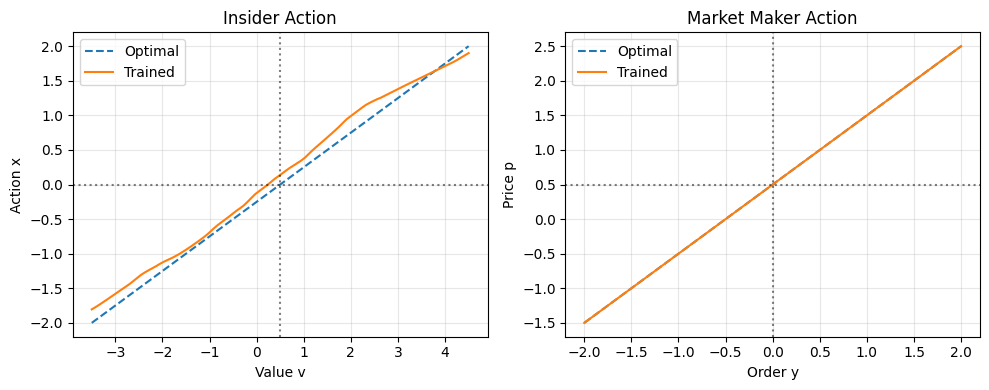

In [17]:
num_episodes = 5000
plot_every = 2500 # 1_000  # if leave "None", will plot 10 times over the course of training
policies_trainI_optMM, optimizers_trainI_optMM = train_both_reinforce_individual(policies_trainI_optMM, optimizers_trainI_optMM, env, num_episodes, plot_every, action_scale_factor)

### Example: training MM vs fixed optimal insider

In [18]:
#### PARAMS ####
action_scale_factor = 5  # defaults to 5 in env & training function definitions
activation_fn = nn.ReLU  # activations for hidden layers. or nn.Tanh (experiment what's better)
output_tanh = False  # if True, puts output through nn.Tanh to ensure [-1,1] (experiment)
hidden_dim = 32
################

env = KyleOnePeriodAEC(action_scaling=action_scale_factor, T=1) 
env.reset()

I_obs_dim = env.observation_spaces["insider"].shape[0]
I_act_dim = env.action_spaces["insider"].shape[0]
MM_obs_dim = env.observation_spaces["market_maker"].shape[0]
MM_act_dim = env.action_spaces["market_maker"].shape[0]
policies_trainMM_optI = {
    "insider": OptimalInsider(p0=env.p0, sigma_v=env.sigma_v, sigma_u=env.sigma_u, action_scaling=action_scale_factor),
    "market_maker": GaussianActor(obs_dim=MM_obs_dim, act_dim=MM_act_dim, hidden_dim=hidden_dim, activation_fn=activation_fn, output_tanh=output_tanh)
}
optimizers_trainMM_optI = {a: optim.Adam(policies_trainMM_optI[a].parameters(), lr=2e-4) for a in policies_trainMM_optI}

Episode: 2500
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])

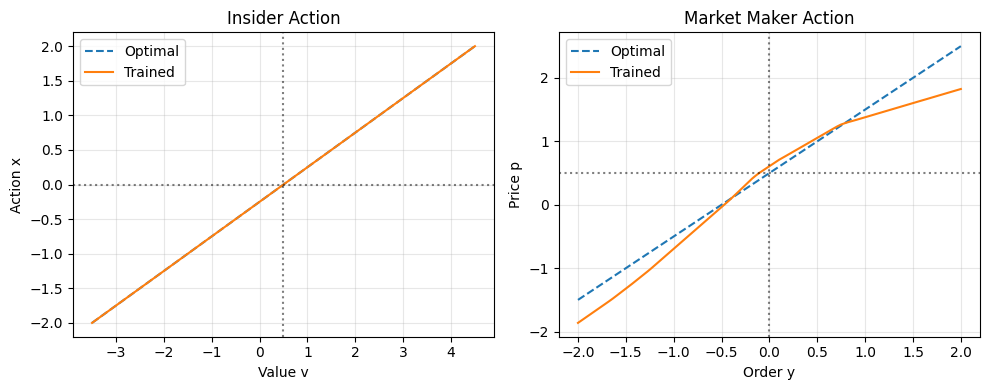

Episode: 5000
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])
tensor([1.0000e-10])

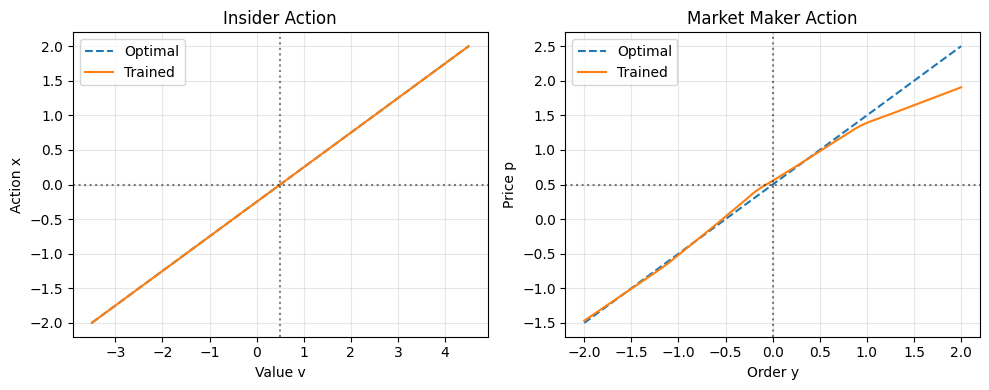

In [19]:
num_episodes = 5000
plot_every = 2500 # 1_000  # if leave "None", will plot 10 times over the course of training
policies_trainMM_optI, optimizers_trainMM_optI = train_both_reinforce_individual(policies_trainMM_optI, optimizers_trainMM_optI, env, num_episodes, plot_every, action_scale_factor)

## Evals

### Eval & plotting function definitions

In [20]:
def plot_profits(values, agent_mean, agent_std, optimal_mean, optimal_std, which_agent="Insider", title=None):
    # Plot
    plt.figure(figsize=(8, 6))

    plt.plot(values, optimal_mean, label=f"optimal", linestyle='--')
    plt.fill_between(values, optimal_mean - optimal_std, optimal_mean + optimal_std, alpha=0.2)

    plt.plot(values, agent_mean, label=f"trained", linestyle='-')
    plt.fill_between(values, agent_mean - agent_std, agent_mean + agent_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    if title is not None:
        plt.title(title)
    else:
        plt.title(f"{which_agent}: Trained vs Optimal Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
def evaluate_profits_bothtrained(env, start_point, end_point, policies, num_points = 100, num_trials = 100, action_scaling=5):
    """calcs insider & MM profits in scenario `trained I vs trained MM` and `optimal I vs optimal MM`"""
    values = np.linspace(start_point, end_point, num_points)
    trained_insider_profits = np.zeros((num_points, num_trials))
    optimal_insider_profits = np.zeros((num_points, num_trials))
    trained_market_maker_profits = np.zeros((num_points, num_trials))
    optimal_market_maker_profits = np.zeros((num_points, num_trials))

    for i in range(num_points):
        v = values[i]
        env.reset()
        obs_I = torch.tensor([v, env.p0, env.sigma_v, env.sigma_u], dtype=torch.float32)
        """
        print(f"obs: {obs}")
        print(f"v value is {env.v}")
        print(f"mu value is {mu}")
        print(f"std value is {std}")
        time.sleep(5)
        """
        # for each value sample, get expected profits (expectation over noise)
        for j in range(num_trials):
            u = np.random.normal(0, env.sigma_u)

            # trained insider vs trained MM
            agent_x = policies["insider"].predict(obs_I, deterministic=True)
            agent_x = agent_x * action_scaling  # scale to actual action
            agent_y = agent_x + u
            obs_MM = torch.tensor([agent_y, env.p0, env.sigma_v, env.sigma_u], dtype=torch.float32)
            agent_p = policies["market_maker"].predict(obs_MM, deterministic=True)
            agent_p = agent_p * action_scaling
            trained_profit_I = (v - agent_p) * agent_x 
            trained_profit_MM = (agent_p - v) * agent_y

            # baseline: optimal insider vs optimal MM
            optimal_x = equilibrium_insider_action(v, env.p0, env.sigma_v, env.sigma_u)
            optimal_y = optimal_x + u
            optimal_p = equilibrium_market_maker_action(optimal_y, env.p0, env.sigma_v, env.sigma_u)
            optimal_profit_I = (v - optimal_p) * optimal_x
            optimal_profit_MM = (optimal_p - v) * optimal_y


            trained_insider_profits[i][j] = trained_profit_I
            optimal_insider_profits[i][j] = optimal_profit_I

            trained_market_maker_profits[i][j] = trained_profit_MM
            optimal_market_maker_profits[i][j] = optimal_profit_MM
        
    return values, trained_insider_profits, optimal_insider_profits, trained_market_maker_profits, optimal_market_maker_profits

def evaluate_insider_profits_vs_optimal_MM(env, start_point, end_point, policies, num_points = 100, num_trials = 50, action_scaling=5):
    """calcs insider profits in scenarios `trained I vs optimal MM` and `optimal I vs optimal MM`"""
    values = np.linspace(start_point, end_point, num_points)
    trained_insider_profits = np.zeros((num_points, num_trials))
    optimal_insider_profits = np.zeros((num_points, num_trials))

    for i in range(num_points):
        v = values[i]
        env.reset()
        obs = torch.tensor([v, env.p0, env.sigma_v, env.sigma_u], dtype=torch.float32)

        for j in range(num_trials):
            u = np.random.normal(0, env.sigma_u)

            # trained insider vs optimal MM
            agent_x = policies["insider"].predict(obs, deterministic=True)
            agent_x = agent_x * action_scaling
            y = agent_x + u
            optimal_p = equilibrium_market_maker_action(y, env.p0, env.sigma_v, env.sigma_u)
            trained_profit_I = (v - optimal_p) * agent_x

            # baseline: optimal insider vs optimal MM
            optimal_x = equilibrium_insider_action(v, env.p0, env.sigma_v, env.sigma_u)
            y = optimal_x + u
            optimal_p2 = equilibrium_market_maker_action(y, env.p0, env.sigma_v, env.sigma_u)
            optimal_profit_I = (v - optimal_p2) * optimal_x

            trained_insider_profits[i][j] = trained_profit_I
            optimal_insider_profits[i][j] = optimal_profit_I
    return values, trained_insider_profits, optimal_insider_profits

### Plots

### Plots: agent actions


tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<ExpandBackward0>)
tensor([0.0676], grad_fn=<Expand

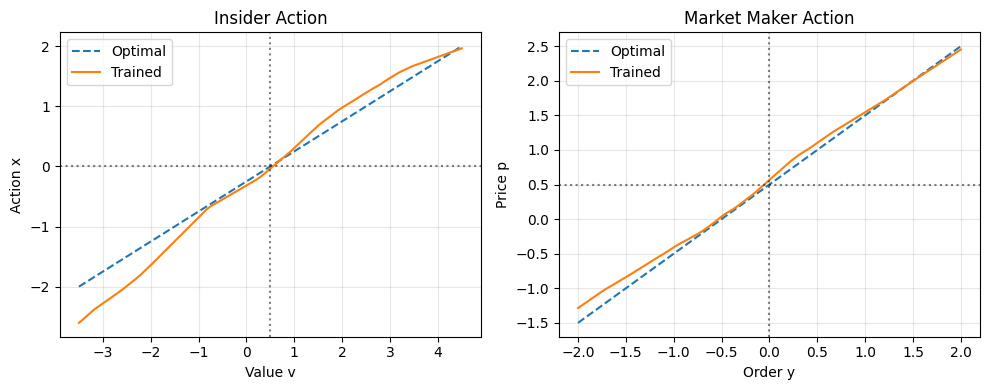

In [22]:
evaluate_agent_actions(policies, env, 2)

#### Plots: agent profits if opponent is same as self (`trained vs trained` and `optimal vs optimal`) 

* Fig1: insider profit
* Fig2: market maker profit

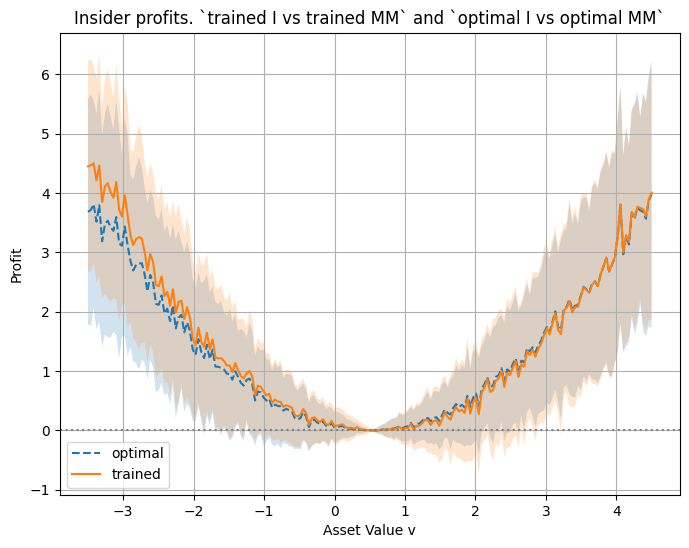

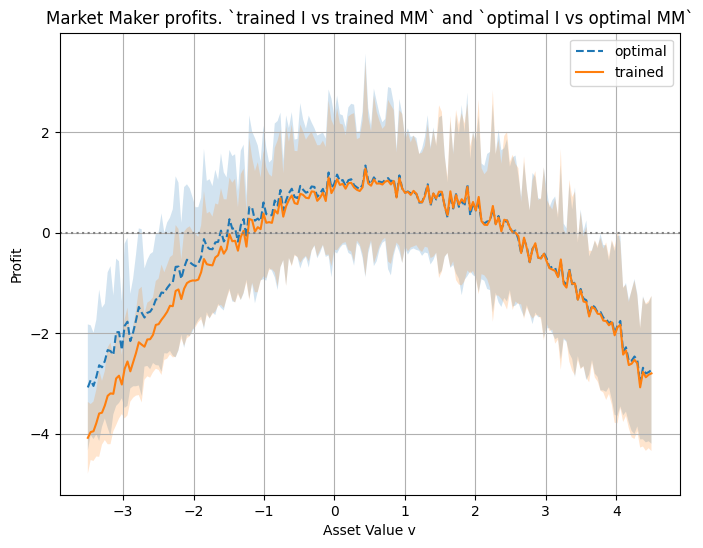

In [23]:
# start_point = -4
# end_point = 5
start_point = env.p0 - 2*env.sigma_v
end_point = env.p0 + 2*env.sigma_v
num_points = 200
num_trials = 100
values, trained_insider_profits, optimal_insider_profits, trained_market_maker_profits, optimal_market_maker_profits = evaluate_profits_bothtrained(env, start_point, end_point, policies, num_points, num_trials)

# Compute mean and std for each point in linspace
trained_insider_mean = trained_insider_profits.mean(axis=1)  # shape (100,)
trained_insider_std = trained_insider_profits.std(axis=1)

optimal_insider_mean = optimal_insider_profits.mean(axis=1)
optimal_insider_std = optimal_insider_profits.std(axis=1)

trained_market_maker_mean = trained_market_maker_profits.mean(axis=1)
trained_market_maker_std = trained_market_maker_profits.std(axis=1)

optimal_market_maker_mean = optimal_market_maker_profits.mean(axis=1)
optimal_market_maker_std = optimal_market_maker_profits.std(axis=1)

title1 = "Insider profits. `trained I vs trained MM` and `optimal I vs optimal MM`"
plot_profits(values, trained_insider_mean, trained_insider_std, optimal_insider_mean, optimal_insider_std, which_agent="Insider", title=title1)

title2 = "Market Maker profits. `trained I vs trained MM` and `optimal I vs optimal MM`"
plot_profits(values, trained_market_maker_mean, trained_market_maker_std, optimal_market_maker_mean, optimal_market_maker_std, which_agent="Market Maker", title=title2)

#### Plots: agent profits if opponent is fixed optimal
Fig1: Insider profit (trained I and optimal I) vs a fixed optimal MM.

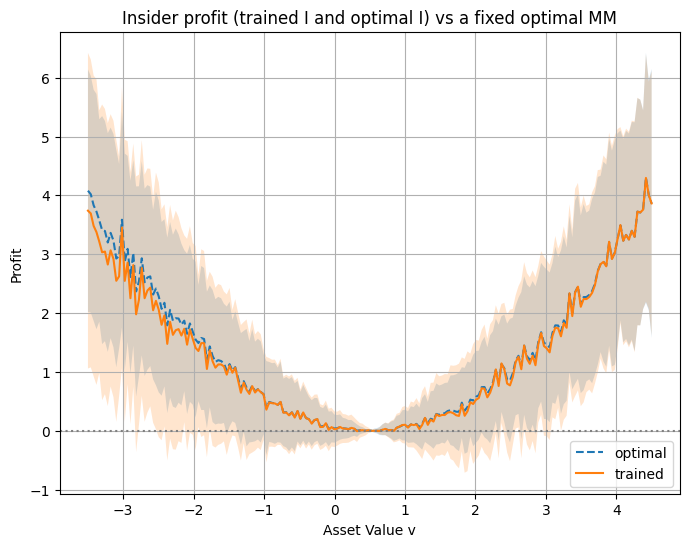

In [24]:
values, trainedIvsoptMM_agent_profits, trainedIvsoptMM_optimal_profits = evaluate_insider_profits_vs_optimal_MM(env, start_point, end_point, policies, num_points, num_trials)
trainedIvsoptMM_agent_mean = trainedIvsoptMM_agent_profits.mean(axis=1)
trainedIvsoptMM_agent_std = trainedIvsoptMM_agent_profits.std(axis=1)
trainedIvsoptMM_optimal_mean = trainedIvsoptMM_optimal_profits.mean(axis=1)
trainedIvsoptMM_optimal_std = trainedIvsoptMM_optimal_profits.std(axis=1)
title3 = "Insider profit (trained I and optimal I) vs a fixed optimal MM"
plot_profits(values, trainedIvsoptMM_agent_mean, trainedIvsoptMM_agent_std, trainedIvsoptMM_optimal_mean, trainedIvsoptMM_optimal_std, which_agent="Insider", title=title3)